### 1. Clean Parquet data from Kaggle (integer dtypes parquet)
- This notebook aims to further clean the data taken from Kaggle's user, without affecting data quality

In [1]:
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format
import matplotlib.pyplot as plt
import gc
import numpy as np
import os
import sys
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")

In [2]:
from pathlib import Path
rootpath = Path.cwd().parent
sys.path.append(os.path.join(rootpath))

In [3]:
from utils.eval_helpers import (
    plot_roc_curves, plot_feature_importance, 
    amex_metric, get_final_metric_df, amex_metric_np, lgb_amex_metric
)
from utils.eda_helpers import (
    plot_missing_proportion_barchart, get_cols, plot_scatterplot, plot_target_check, 
    plot_int_feature_distribution, plot_train_test_distribution, check_overlap_missing,
    insert_row_number
)
from utils.extraction_helpers import read_file
from utils.feature_group import (
    CATEGORY_COLUMNS, CONTINUOUS_COLUMNS, BINARY_COLUMNS, ROUND_COLUMNS,
    MEAN_FEATURES, MIN_FEATURES, MAX_FEATURES, LAST_FEATURES, NON_FEATURE_COLUMNS
)
from utils.constants import (
    PROCESSED_DATA_PATH
)
from utils.feature_engineering_helpers import integerize

In [4]:
RAW_DATA_PATH = "../raw_data"
PROCESSED_DATA_PATH = "../processed_data"
SUBMISSION_DATA_PATH = "../submissions"
EVALUATION_DATA_PATH = "../evaluation_data"
MODELS_PATH = "../models"

In [5]:
RAW_TRAIN_PARQUET_PATH = os.path.join(RAW_DATA_PATH, "train_parquet")
RAW_TRAIN_PICKLE_PATH = os.path.join(RAW_DATA_PATH, "train_pickle")
RAW_TEST_PARQUET_PATH = os.path.join(RAW_DATA_PATH, "test_parquet")
RAW_TEST_PICKLE_PATH = os.path.join(RAW_DATA_PATH, "test_pickle")

In [6]:
%load_ext autoreload
%autoreload

### Read Data

In [7]:
%%time
train = read_file(f"{RAW_TRAIN_PARQUET_PATH}/train_bd.parquet", replace_negative_one=True)
test = read_file(f"{RAW_TEST_PARQUET_PATH}/test_bd.parquet", replace_negative_one=True)

Shape of data: (5531451, 189)
Shape of data: (11363762, 188)
CPU times: user 15.5 s, sys: 16.2 s, total: 31.7 s
Wall time: 19.5 s


In [8]:
labels = pd.read_csv(f"{RAW_DATA_PATH}/train_labels.csv")

In [9]:
%%time
if "target" not in train.columns:
    train = train.merge(labels, on="customer_ID", how="left")

CPU times: user 10 µs, sys: 28 µs, total: 38 µs
Wall time: 41 µs


In [10]:
print(sorted(get_cols(train, ["S_", "P_"])))

['P_2', 'P_3', 'P_4', 'S_11', 'S_12', 'S_13', 'S_15', 'S_16', 'S_17', 'S_18', 'S_19', 'S_2', 'S_20', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'S_27', 'S_3', 'S_5', 'S_6', 'S_7', 'S_8', 'S_9']


### P_2

45985 null count, 0.008 null proportion
0.2561 of the targets have label = 1


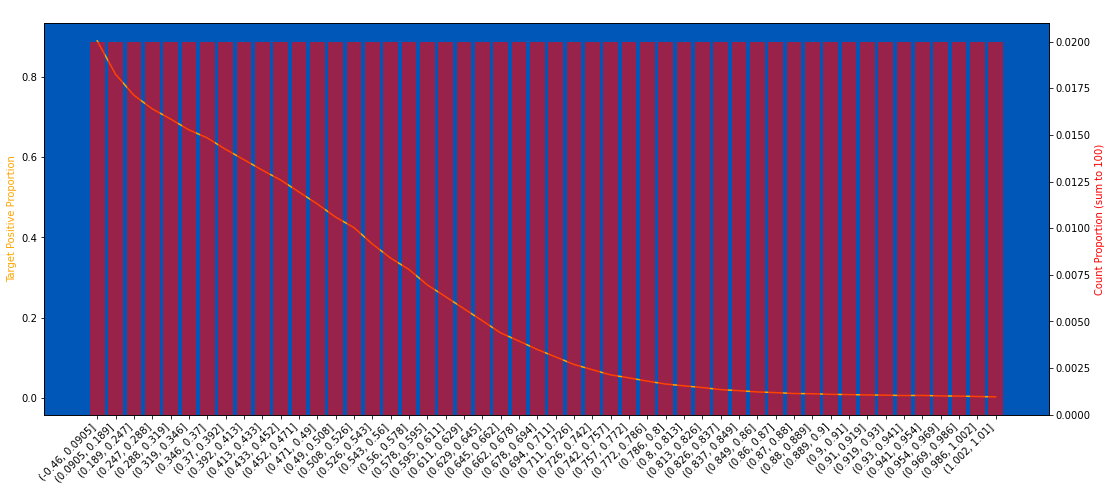

In [11]:
plot_target_check(train, "P_2", q=50, use_raw_bin=True)

### P_3

301492 null count, 0.055 null proportion
0.4439 of the targets have label = 1


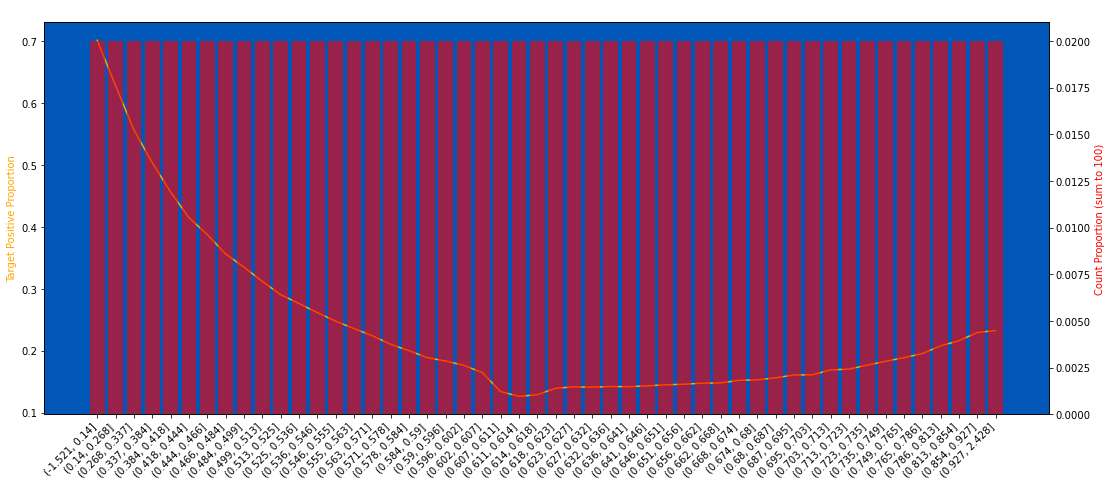

In [12]:
plot_target_check(train, "P_3", q=50, use_raw_bin=True)

### P_4

0 null count, 0.000 null proportion
nan of the targets have label = 1


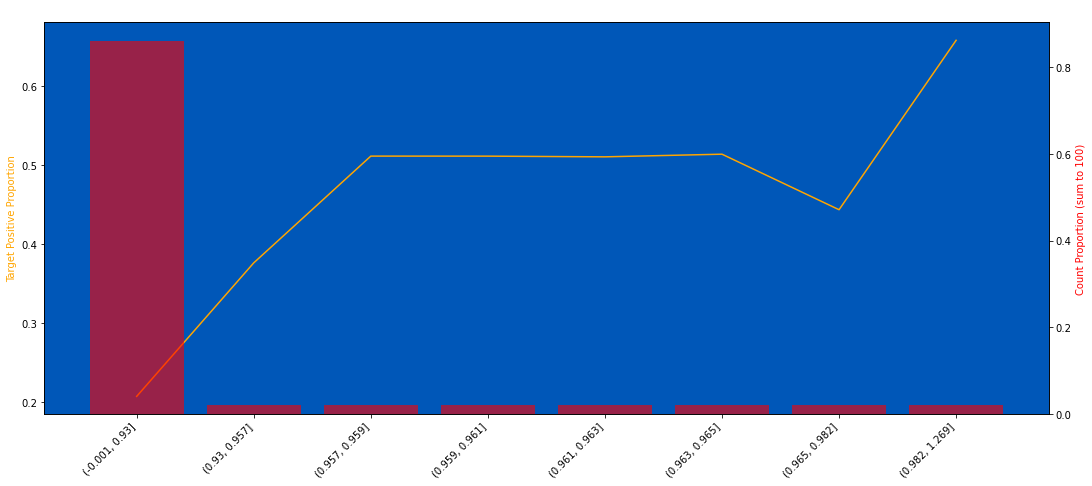

In [13]:
plot_target_check(train, "P_4", q=50, use_raw_bin=True)

### S_3

1020544 null count, 0.184 null proportion
0.1064 of the targets have label = 1


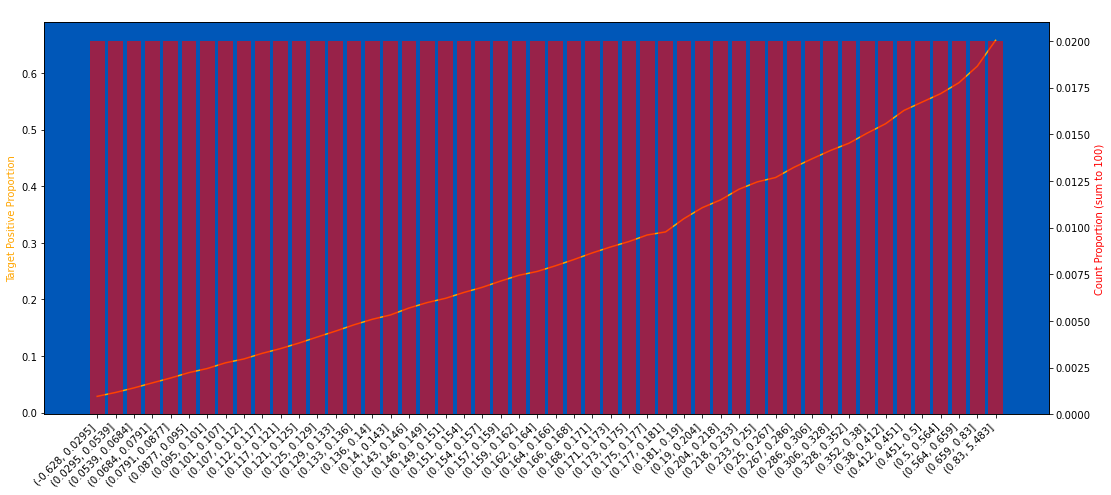

In [14]:
plot_target_check(train, "S_3", q=50, use_raw_bin=True)

In [15]:
train["S_3"] = train["S_3"].round(3)
test["S_3"] = test["S_3"].round(3)

1020544 null count, 0.184 null proportion
0.1064 of the targets have label = 1


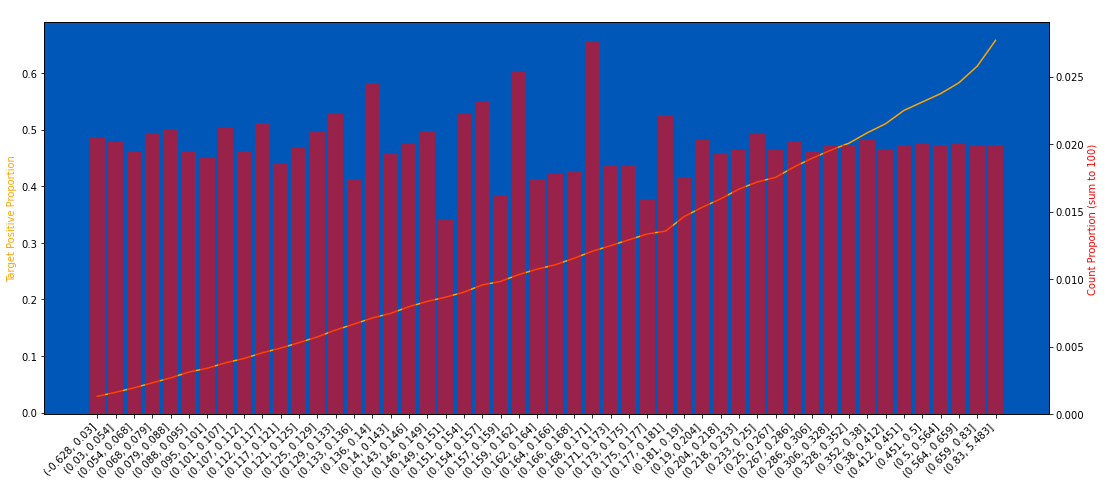

In [16]:
plot_target_check(train, "S_3", q=50, use_raw_bin=True)

### S_5

0 null count, 0.000 null proportion
nan of the targets have label = 1


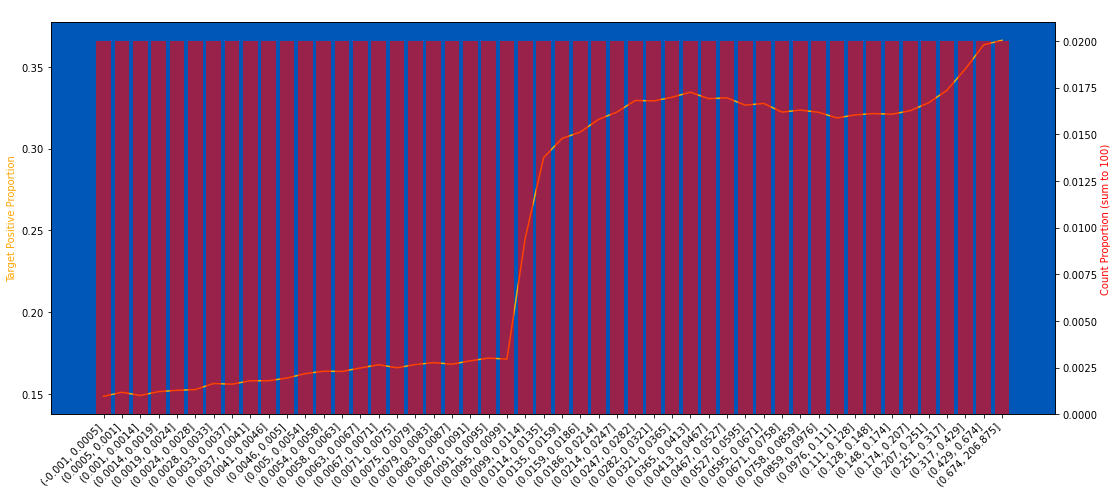

In [17]:
plot_target_check(train, "S_5", q=50, use_raw_bin=True)

In [18]:
train["S_5"] = train["S_5"].round(3)
test["S_5"] = test["S_5"].round(3)

In [19]:
train.loc[train["S_5"].between(-0.02, 0.01), "S_5"] = 0.01
test.loc[test["S_5"].between(-0.02, 0.01), "S_5"] = 0.01

0 null count, 0.000 null proportion
nan of the targets have label = 1


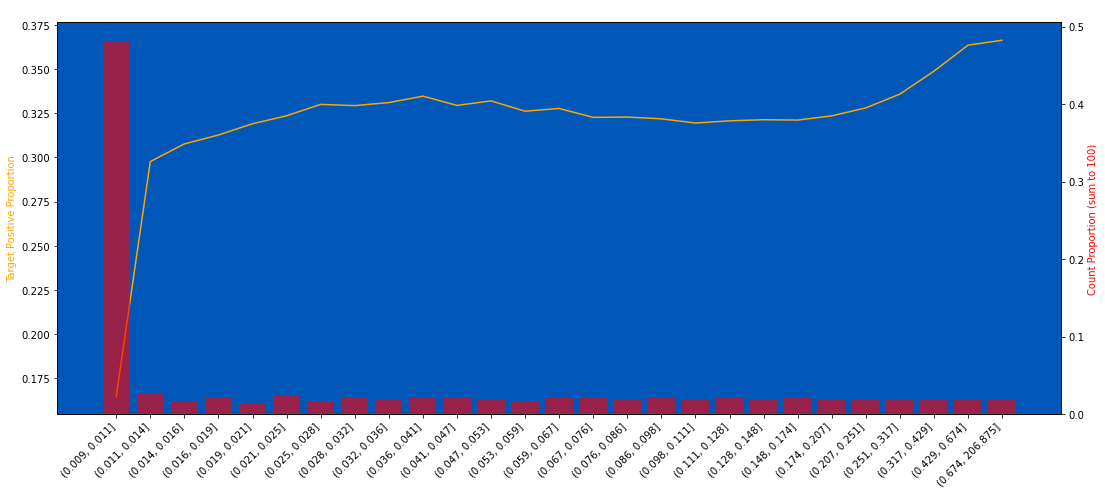

In [20]:
plot_target_check(train, "S_5", q=50, use_raw_bin=True)

### S_6

0 null count, 0.000 null proportion
nan of the targets have label = 1


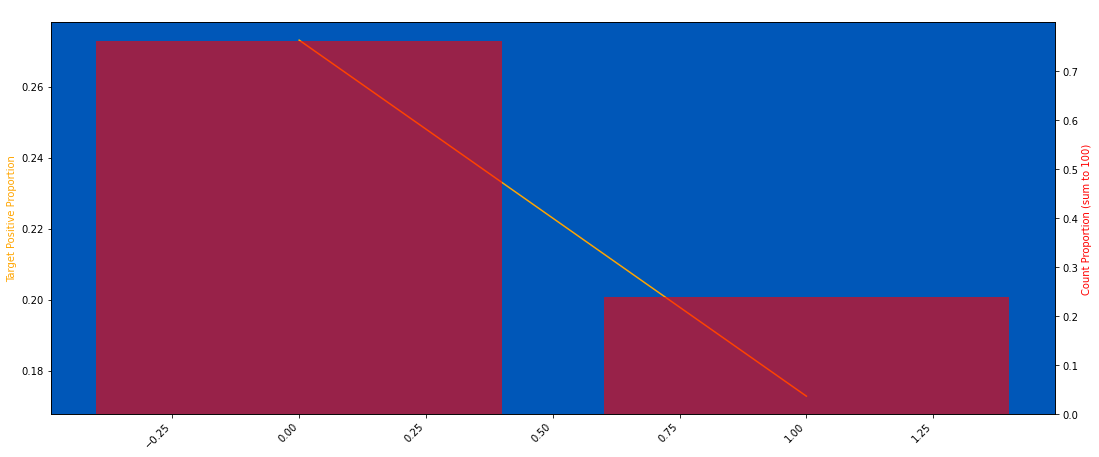

In [21]:
plot_target_check(train, "S_6", q=50, use_raw_bin=True)

### S_7

1020544 null count, 0.184 null proportion
0.1064 of the targets have label = 1


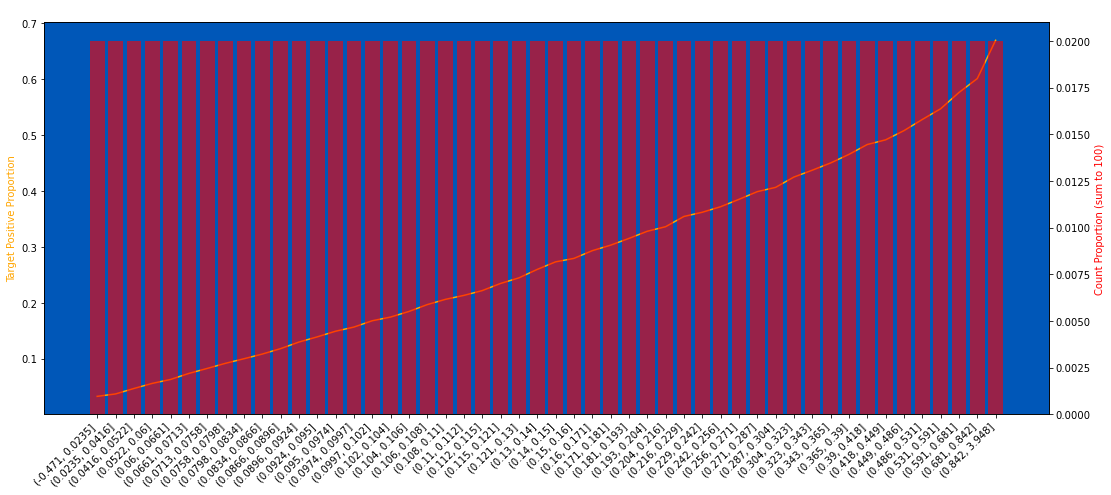

In [22]:
plot_target_check(train, "S_7", q=50, use_raw_bin=True)

In [23]:
train["S_7"] = train["S_7"].round(3)
test["S_7"] = test["S_7"].round(3)

1020544 null count, 0.184 null proportion
0.1064 of the targets have label = 1


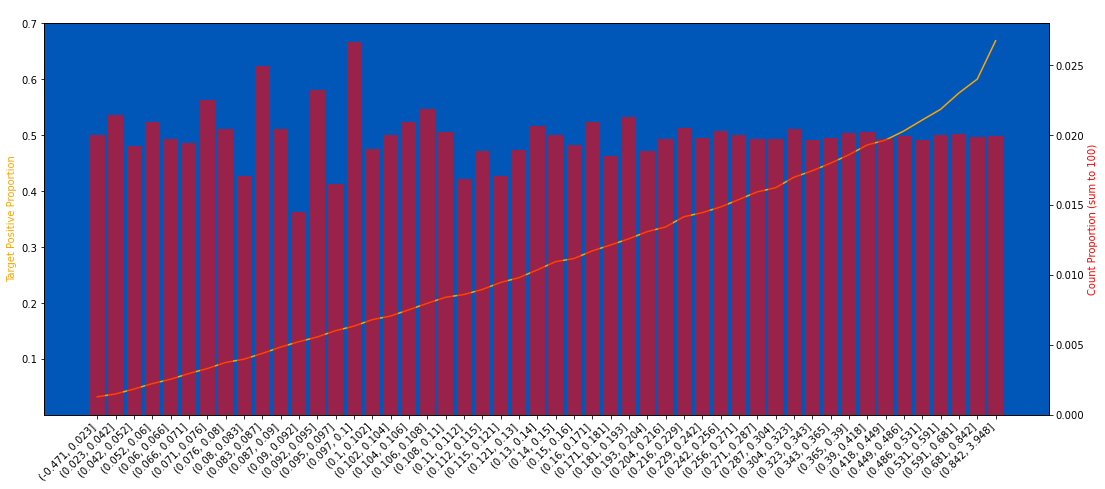

In [24]:
plot_target_check(train, "S_7", q=50, use_raw_bin=True)

### S_8

0 null count, 0.000 null proportion
nan of the targets have label = 1


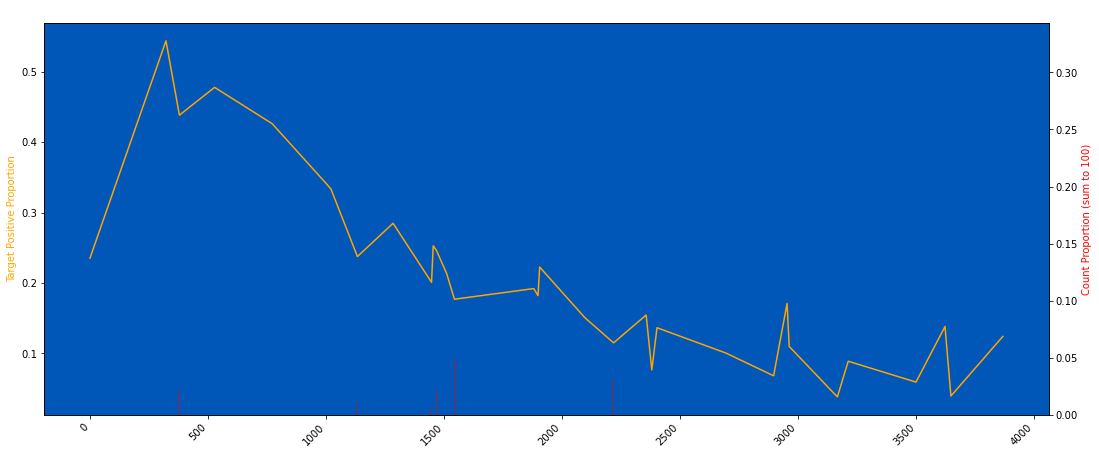

In [25]:
plot_target_check(train, "S_8", q=50, use_raw_bin=True)

In [26]:
train["S_8"].unique()

array([2896, 3166, 2218, 2380, 1544, 1880, 1468, 2096, 2402, 1021,    0,
       1133,  996, 1284, 1454, 1511,  528,  772,  379,  322, 1898, 2694,
       3647, 1447, 3212, 2356, 3499, 3867, 1905, 2962, 3622, 2953],
      dtype=int16)

### S_9

2933643 null count, 0.530 null proportion
0.2719 of the targets have label = 1


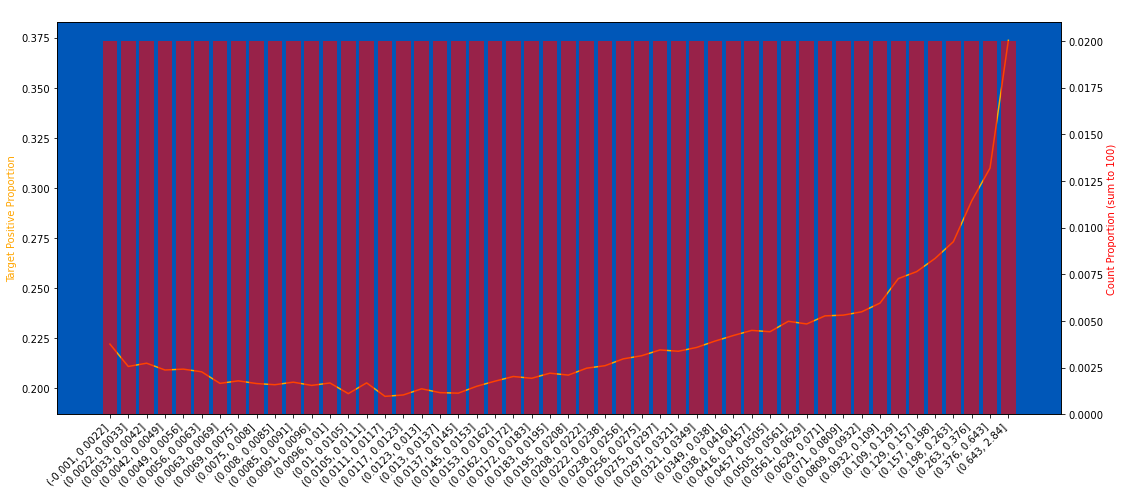

In [27]:
plot_target_check(train, "S_9", q=50, use_raw_bin=True)

In [28]:
train["S_9"] = train["S_9"].round(2)
test["S_9"] = test["S_9"].round(2)

2933643 null count, 0.530 null proportion
0.2719 of the targets have label = 1


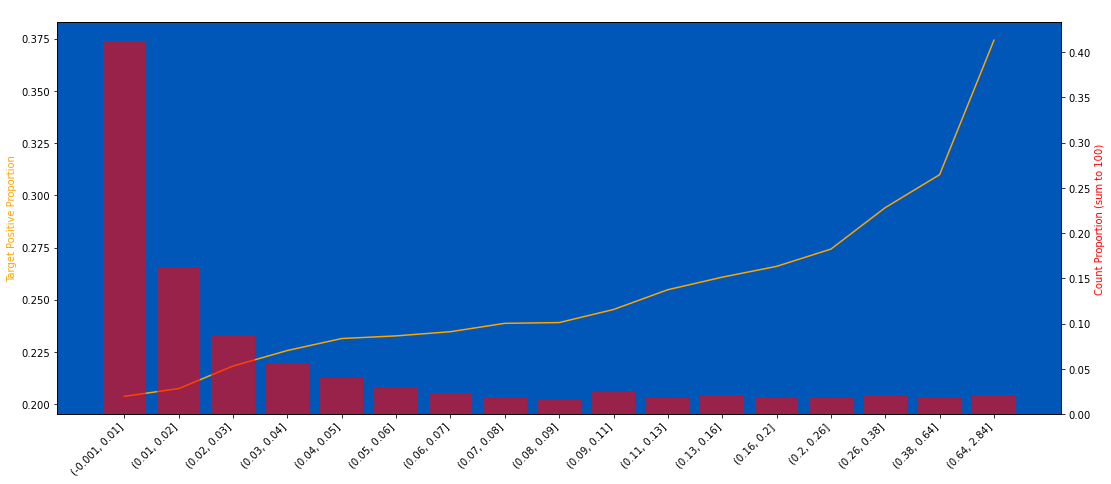

In [29]:
plot_target_check(train, "S_9", q=50, use_raw_bin=True)

### S_11

0 null count, 0.000 null proportion
nan of the targets have label = 1


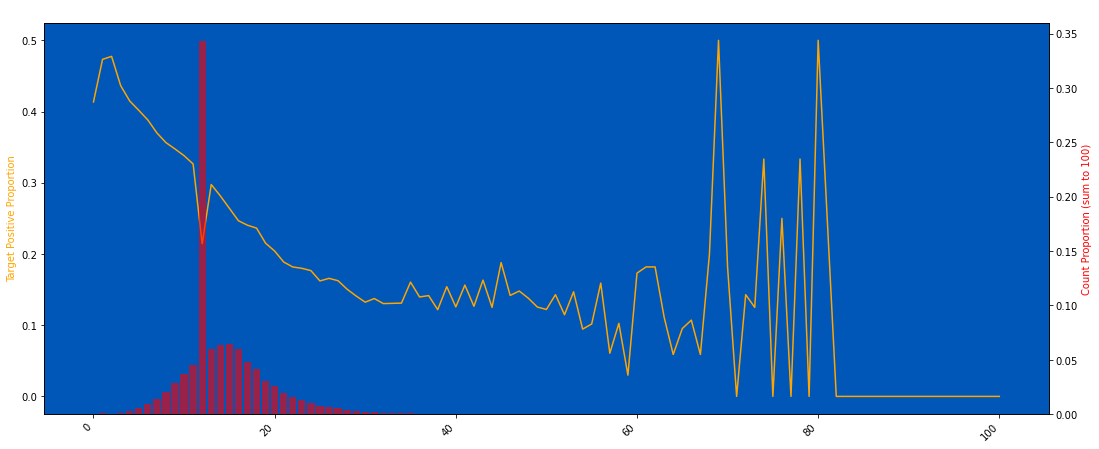

In [30]:
plot_target_check(train, "S_11", q=50, use_raw_bin=True)

In [31]:
train["S_11"].mode()

0    12
Name: S_11, dtype: int8

### S_12

0 null count, 0.000 null proportion
nan of the targets have label = 1


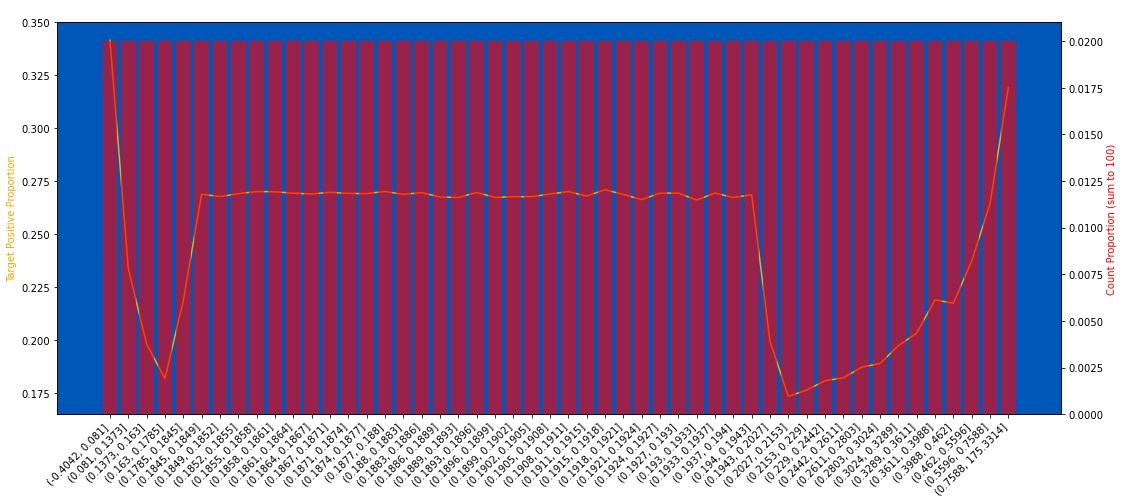

In [32]:
plot_target_check(train, "S_12", q=50, use_raw_bin=True)

In [33]:
train["S_12"] = train["S_12"].round(2)
test["S_12"] = test["S_12"].round(2)

0 null count, 0.000 null proportion
nan of the targets have label = 1


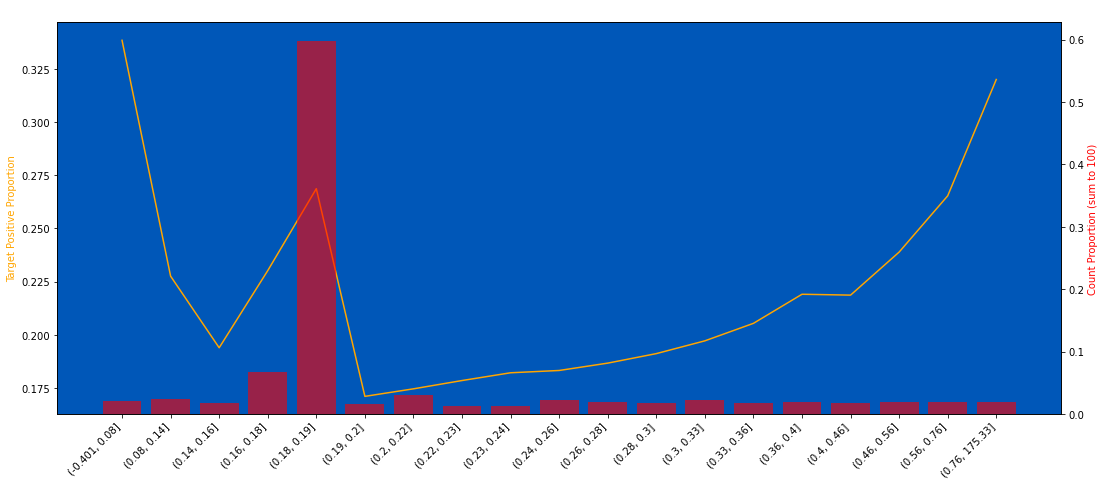

In [34]:
plot_target_check(train, "S_12", q=50, use_raw_bin=True)

### S_13

0 null count, 0.000 null proportion
nan of the targets have label = 1


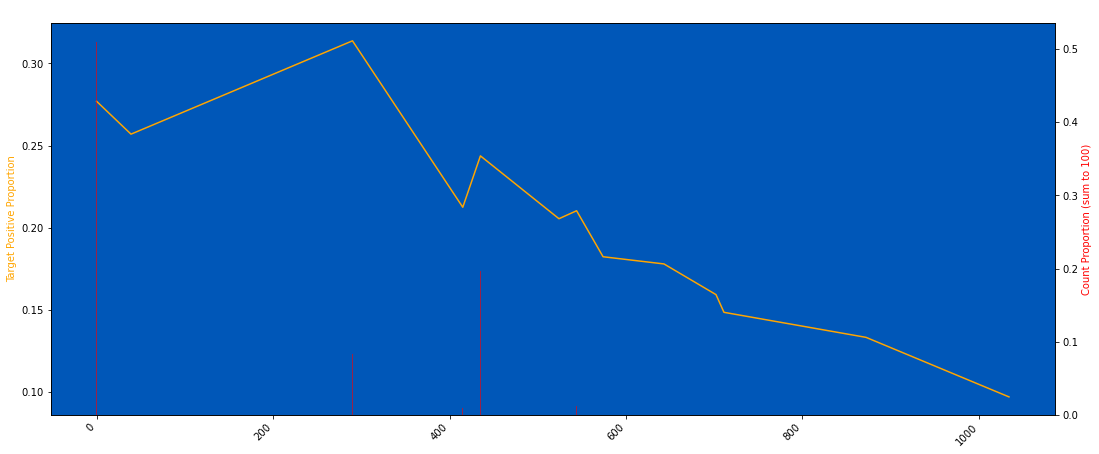

In [35]:
plot_target_check(train, "S_13", q=50, use_raw_bin=True)

### S_15

0 null count, 0.000 null proportion
nan of the targets have label = 1


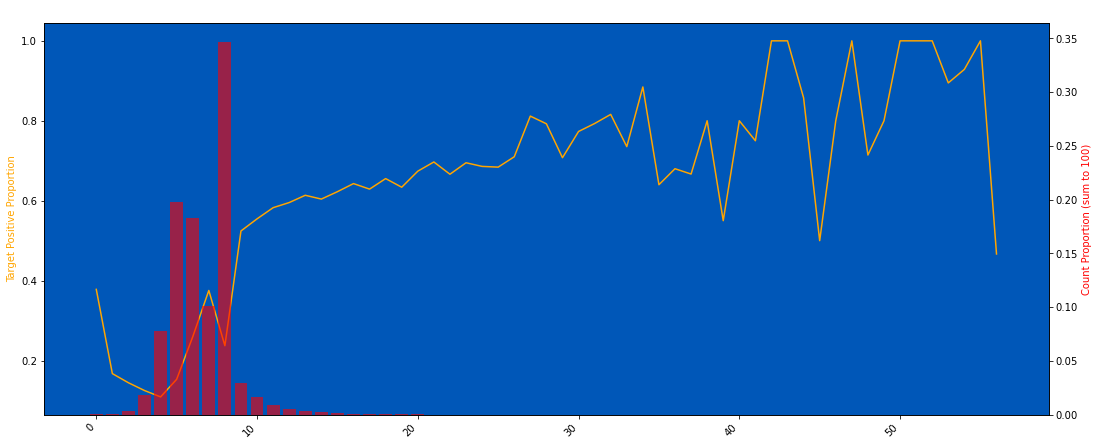

In [36]:
plot_target_check(train, "S_15", q=50, use_raw_bin=True)

### S_16

0 null count, 0.000 null proportion
nan of the targets have label = 1


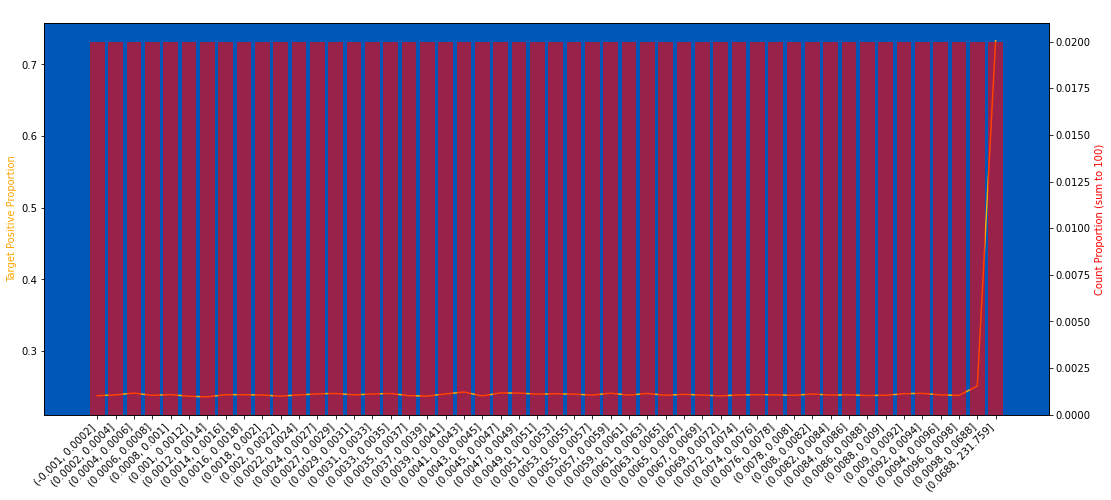

In [37]:
plot_target_check(train, "S_16", q=50, use_raw_bin=True)

In [38]:
train["S_16"] = train["S_16"].round(2)
test["S_16"] = test["S_16"].round(2)

0 null count, 0.000 null proportion
nan of the targets have label = 1


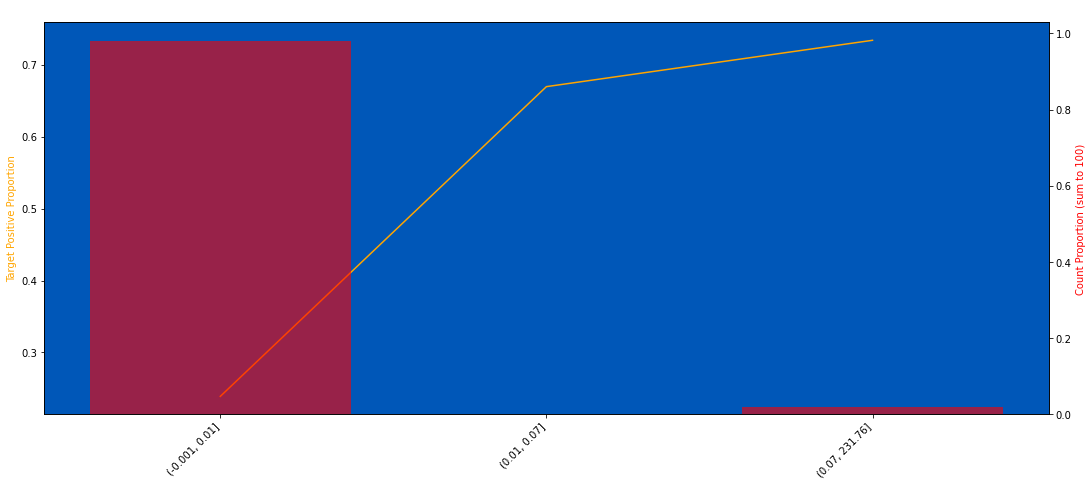

In [39]:
plot_target_check(train, "S_16", q=50, use_raw_bin=True)

### S_17

0 null count, 0.000 null proportion
nan of the targets have label = 1


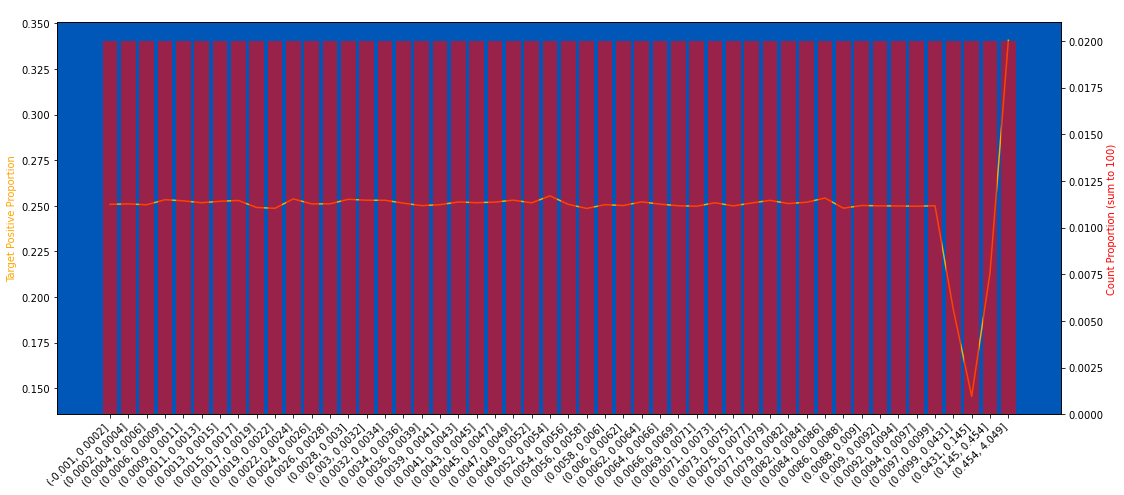

In [40]:
plot_target_check(train, "S_17", q=50, use_raw_bin=True)

In [41]:
train["S_17"] = train["S_17"].round(2)
test["S_17"] = test["S_17"].round(2)

0 null count, 0.000 null proportion
nan of the targets have label = 1


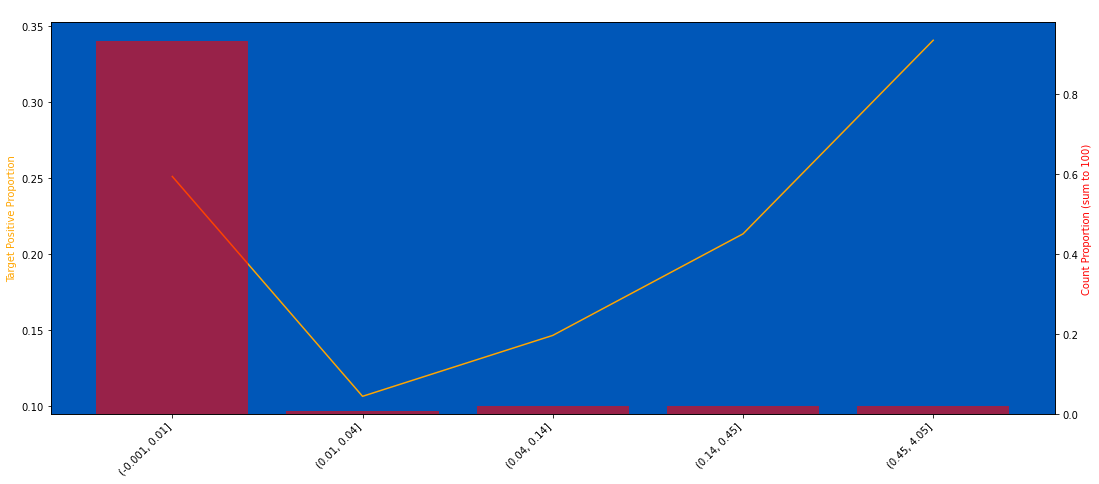

In [42]:
plot_target_check(train, "S_17", q=50, use_raw_bin=True)

### S_18

0 null count, 0.000 null proportion
nan of the targets have label = 1


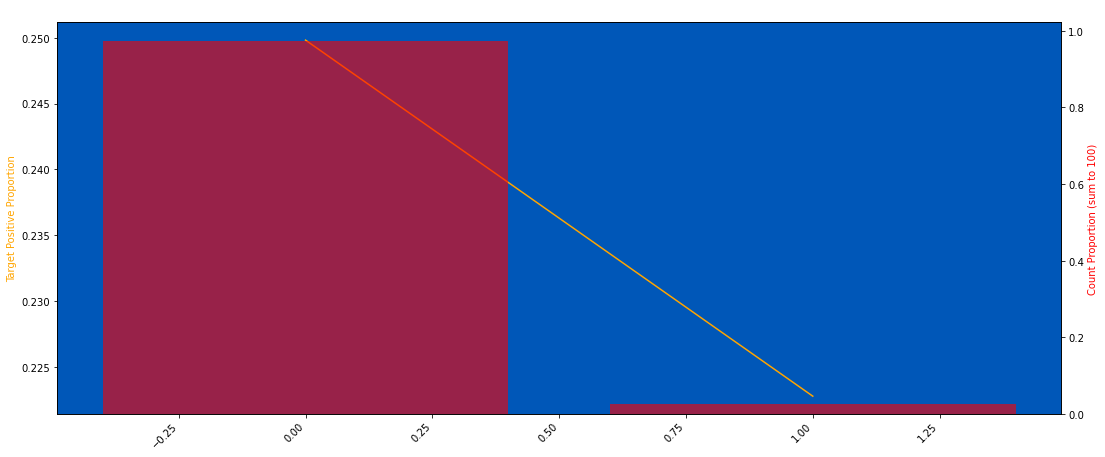

In [43]:
plot_target_check(train, "S_18", q=50, use_raw_bin=True)

### S_19

0 null count, 0.000 null proportion
nan of the targets have label = 1


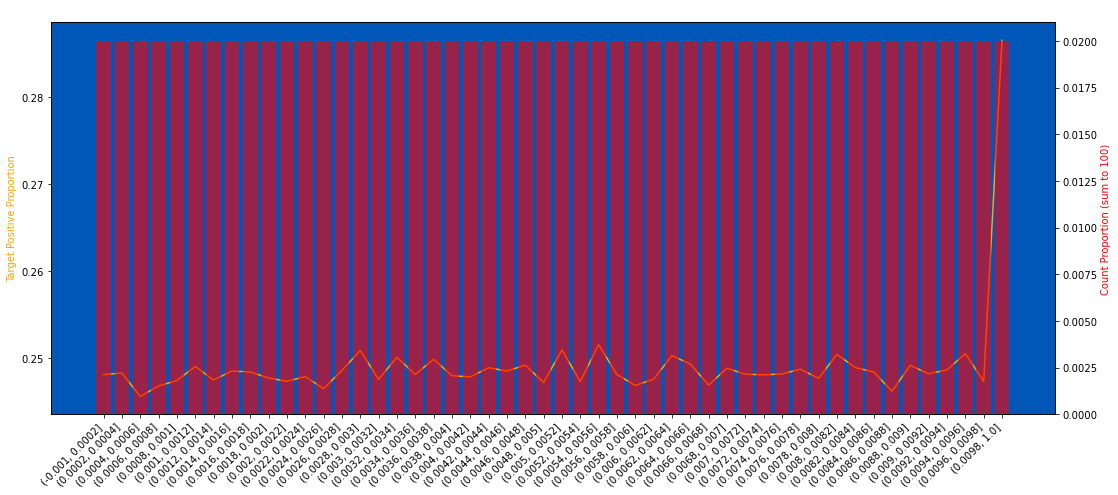

In [44]:
plot_target_check(train, "S_19", q=50, use_raw_bin=True)

In [45]:
train["S_19"] = train["S_19"].round(2)
test["S_19"] = test["S_19"].round(2)

0 null count, 0.000 null proportion
nan of the targets have label = 1


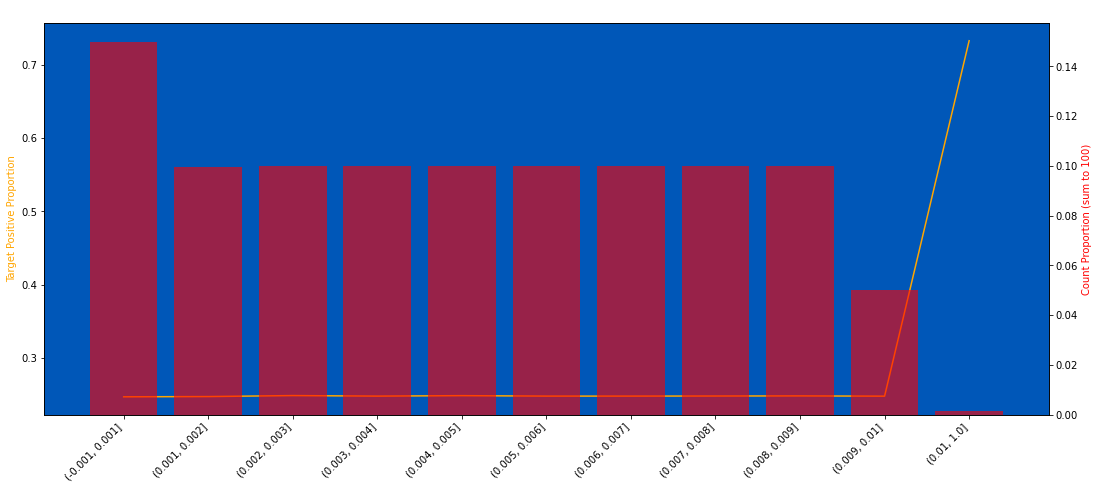

In [46]:
plot_target_check(train, "S_19", q=50, use_raw_bin=True)

### S_20

0 null count, 0.000 null proportion
nan of the targets have label = 1


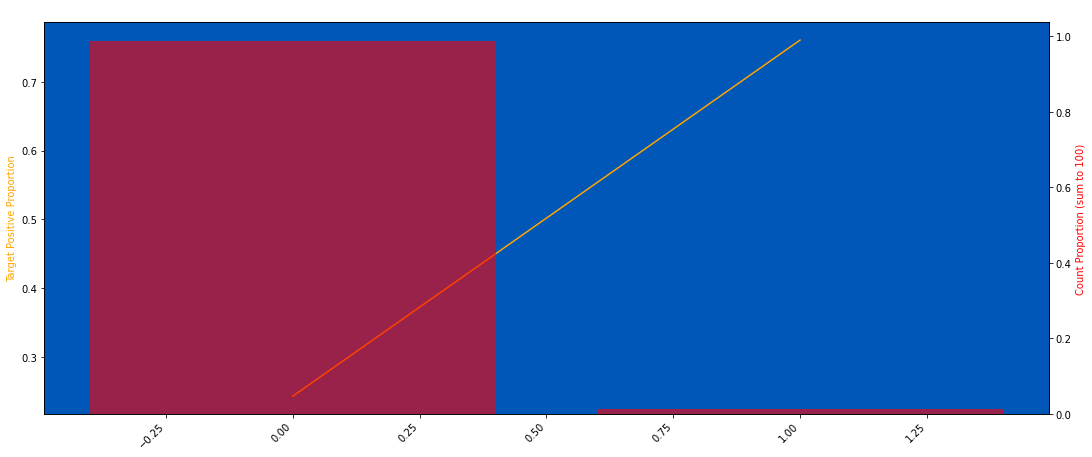

In [47]:
plot_target_check(train, "S_20", q=50, use_raw_bin=True)

### S_22

19024 null count, 0.003 null proportion
0.1320 of the targets have label = 1


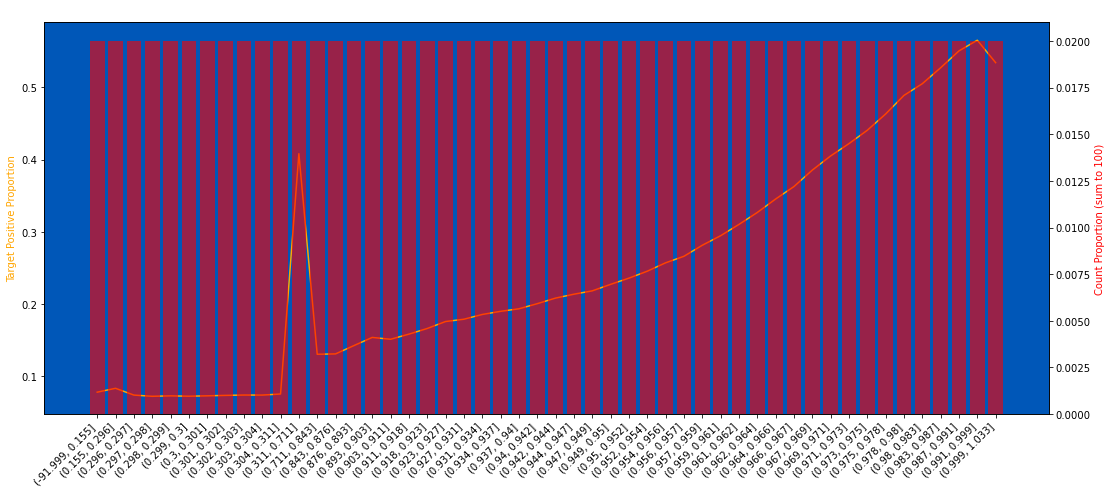

In [48]:
plot_target_check(train, "S_22", q=50, use_raw_bin=True)

### S_23

445 null count, 0.000 null proportion
0.5236 of the targets have label = 1


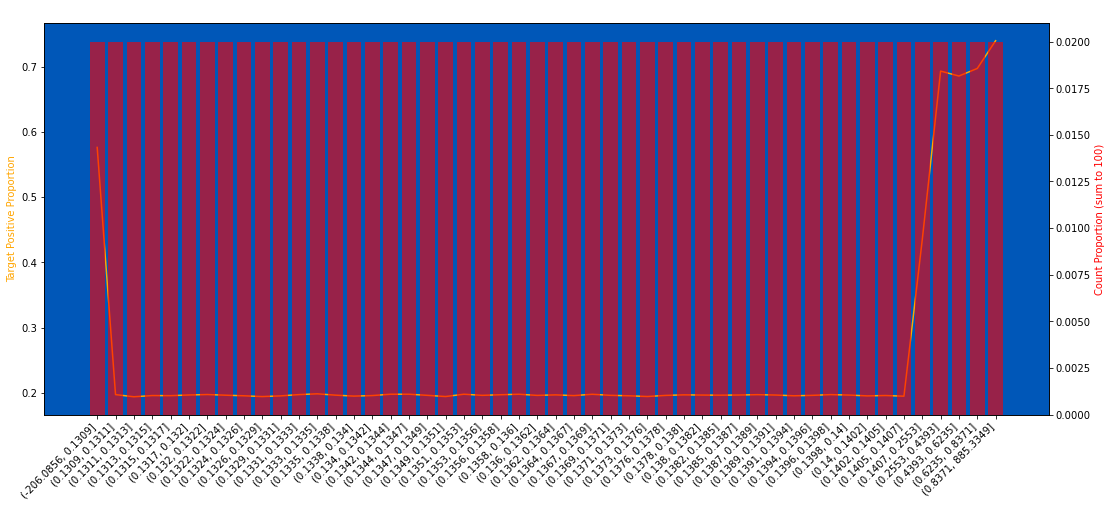

In [49]:
plot_target_check(train, "S_23", q=50, use_raw_bin=True)

In [50]:
train["S_23"] = train["S_23"].round(2)
test["S_23"] = test["S_23"].round(2)

445 null count, 0.000 null proportion
0.5236 of the targets have label = 1


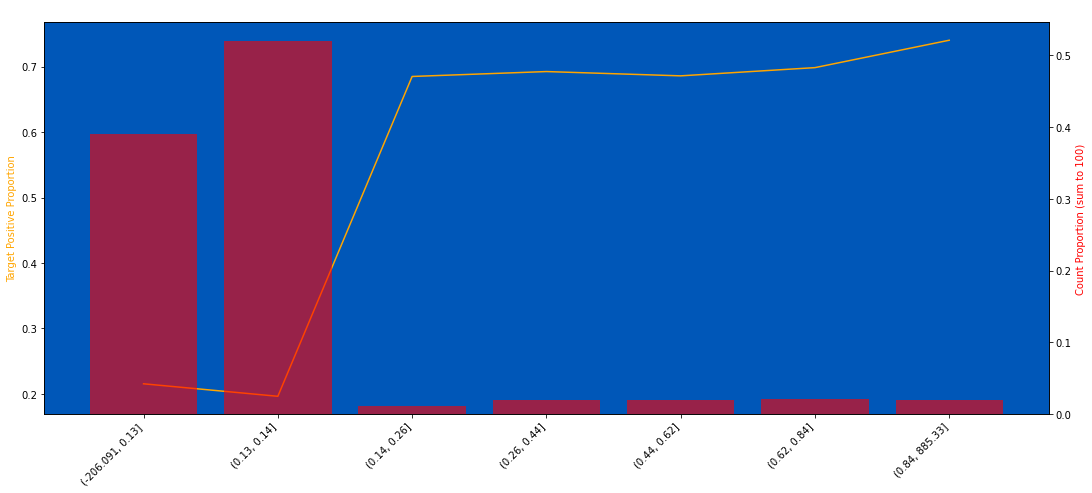

In [51]:
plot_target_check(train, "S_23", q=50, use_raw_bin=True)

### S_24

18593 null count, 0.003 null proportion
0.1317 of the targets have label = 1


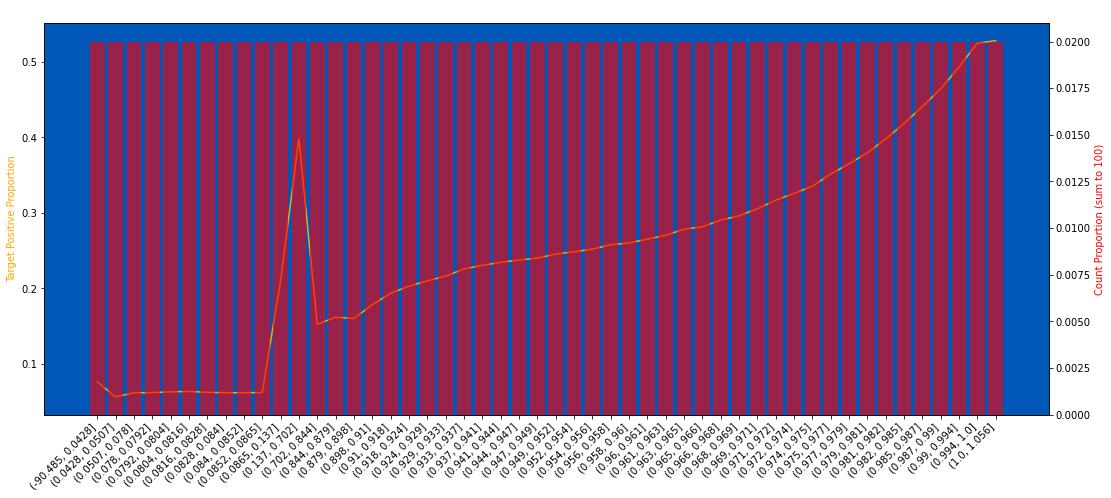

In [52]:
plot_target_check(train, "S_24", q=50, use_raw_bin=True)

In [53]:
train["S_24"] = train["S_24"].round(2)
test["S_24"] = test["S_24"].round(2)

In [54]:
train.loc[train["S_24"].between(1, 1.1), "S_24"] = 1
test.loc[test["S_24"].between(1, 1.1), "S_24"] = 1

18593 null count, 0.003 null proportion
0.1317 of the targets have label = 1


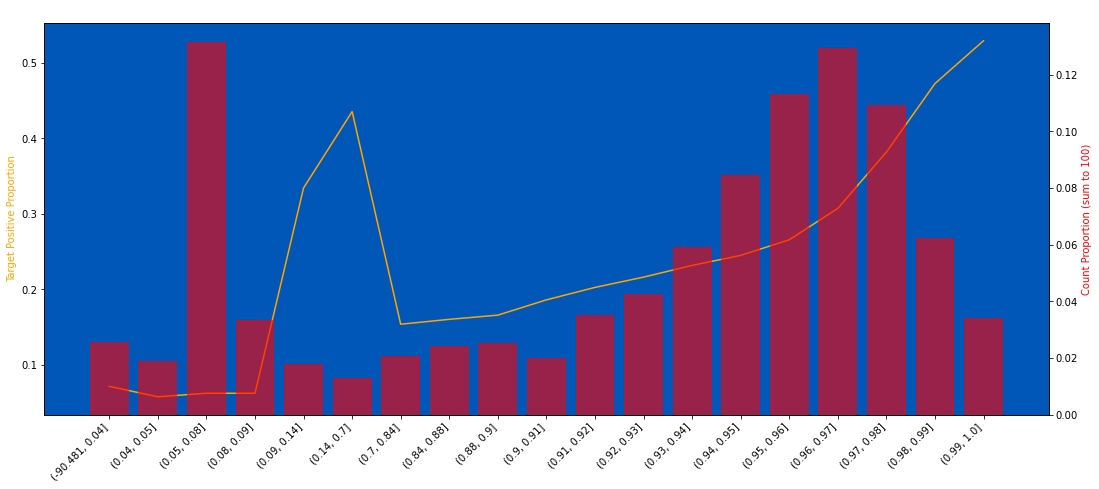

In [55]:
plot_target_check(train, "S_24", q=50, use_raw_bin=True)

### S_25

12847 null count, 0.002 null proportion
0.6575 of the targets have label = 1


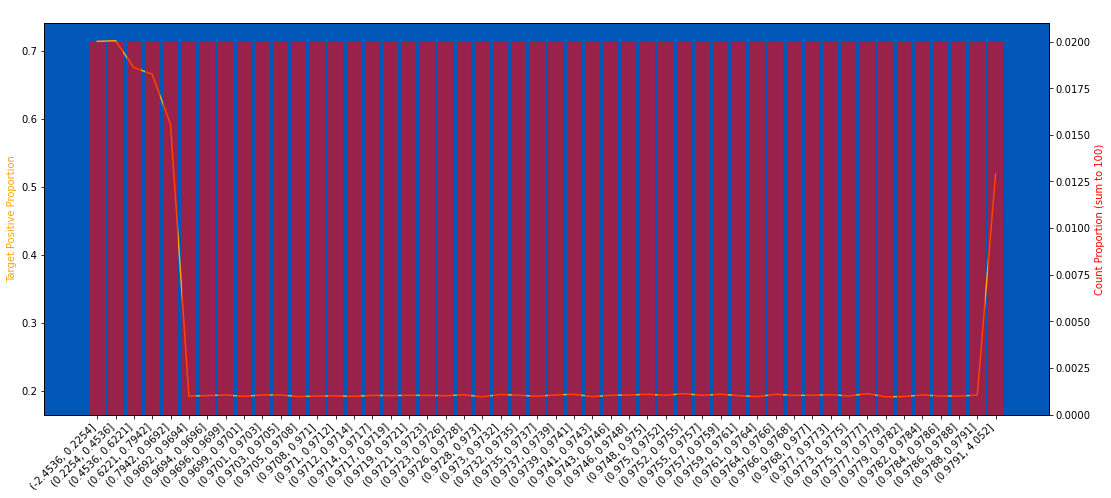

In [56]:
plot_target_check(train, "S_25", q=50, use_raw_bin=True)

In [57]:
train["S_25"] = train["S_25"].round(2)
test["S_25"] = test["S_25"].round(2)

12847 null count, 0.002 null proportion
0.6575 of the targets have label = 1


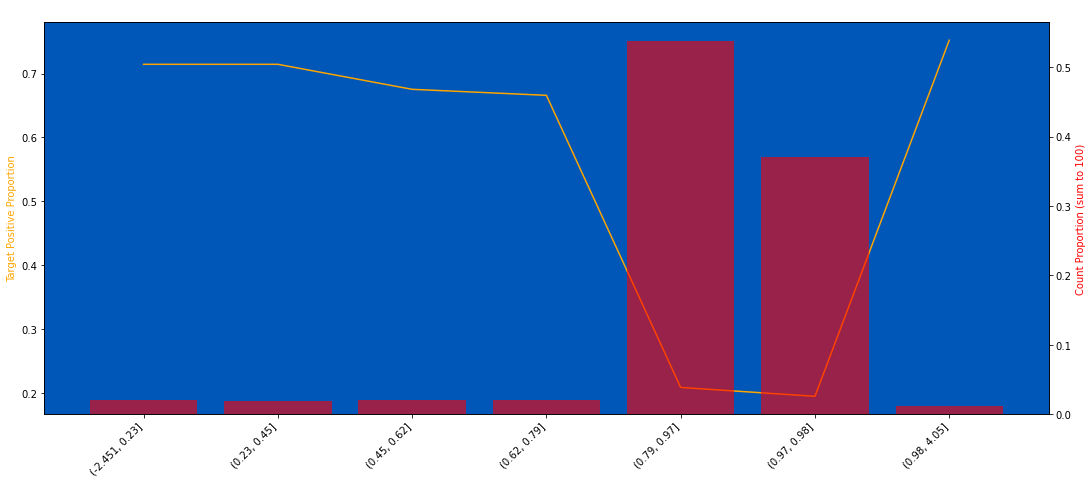

In [58]:
plot_target_check(train, "S_25", q=50, use_raw_bin=True)

### S_26

634 null count, 0.000 null proportion
0.1325 of the targets have label = 1


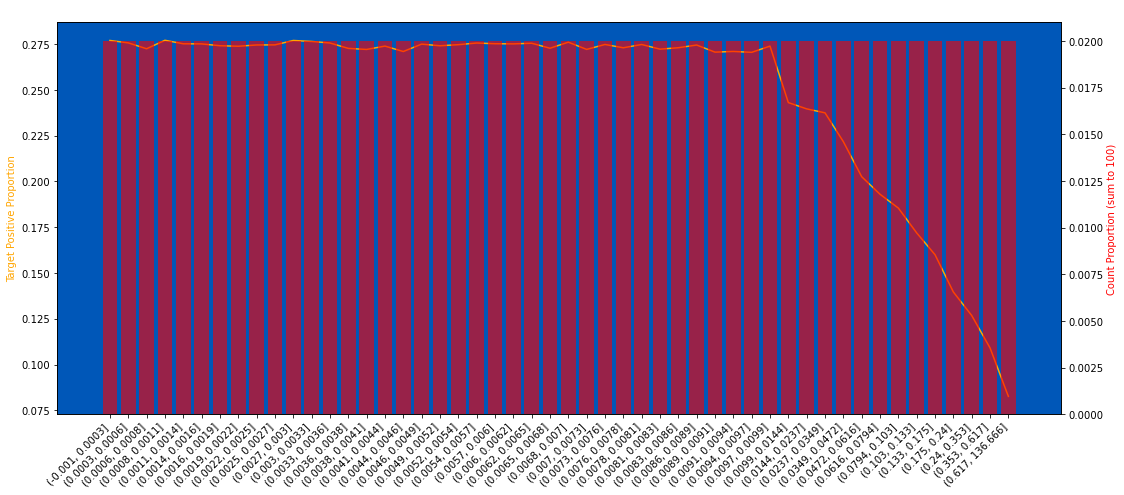

In [59]:
plot_target_check(train, "S_26", q=50, use_raw_bin=True)

In [60]:
train["S_26"] = train["S_26"].round(2)
test["S_26"] = test["S_26"].round(2)

634 null count, 0.000 null proportion
0.1325 of the targets have label = 1


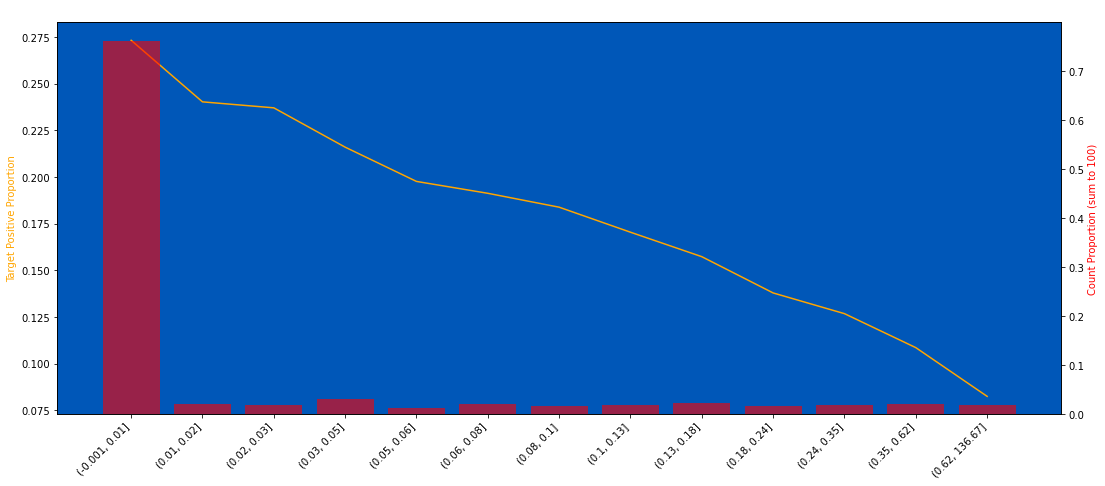

In [61]:
plot_target_check(train, "S_26", q=50, use_raw_bin=True)

### S_27

1400935 null count, 0.253 null proportion
0.1697 of the targets have label = 1


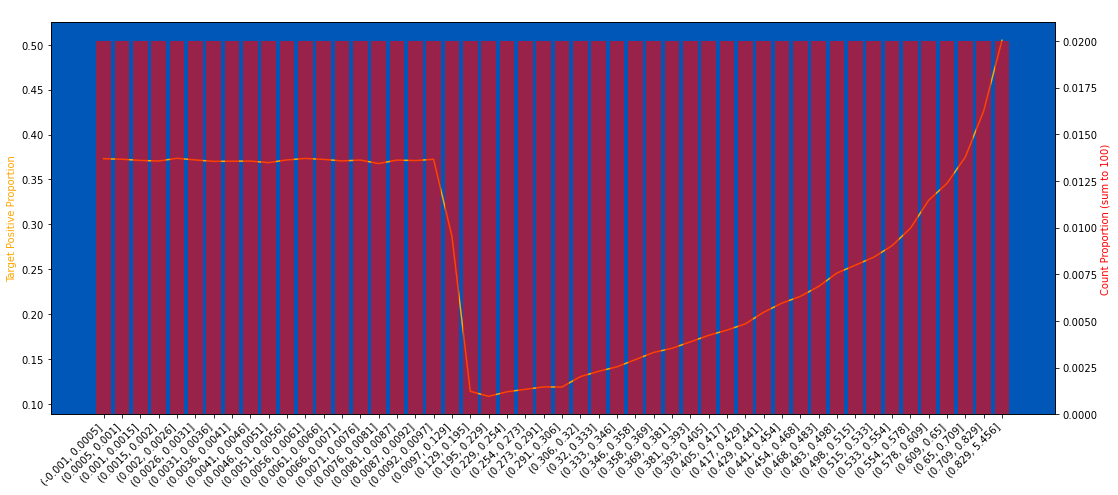

In [63]:
plot_target_check(train, "S_27", q=50, use_raw_bin=True)

In [64]:
train["S_27"] = train["S_27"].round(2)
test["S_27"] = test["S_27"].round(2)

1400935 null count, 0.253 null proportion
0.1697 of the targets have label = 1


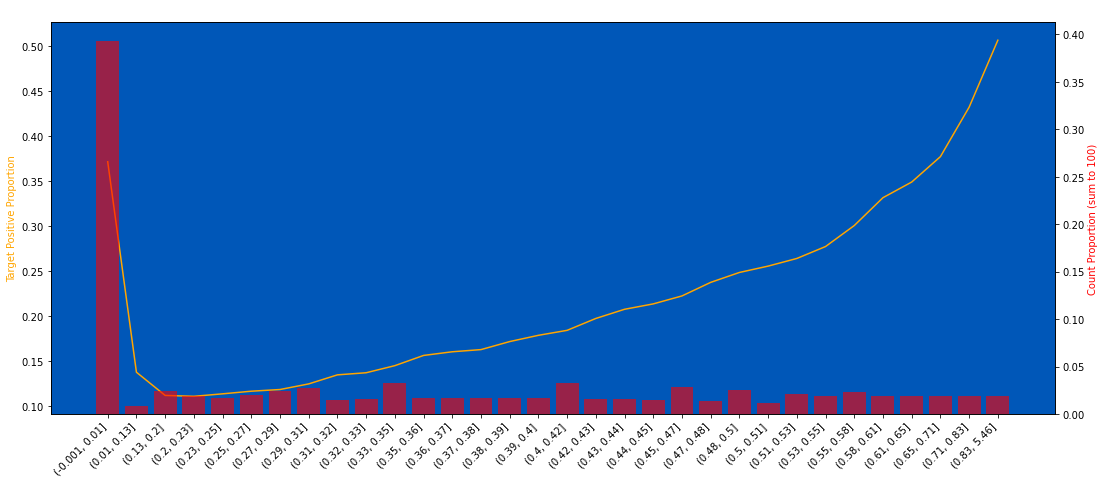

In [65]:
plot_target_check(train, "S_27", q=50, use_raw_bin=True)

### Column checking

In [66]:
from tqdm import tqdm

In [67]:
all_columns = get_cols(train, ["P_", "S_"])

In [72]:
for d in tqdm(all_columns):
    neg1_series = train.loc[train[d] == -1, d]
    if len(neg1_series) > 0:
        print("Train", d, len(neg1_series))
        train[d] = train[d].replace(-1, -0.99)
    neg1_series = test.loc[test[d] == -1, d]
    if len(neg1_series) > 0:
        print("Test", d, len(neg1_series))
        test[d] = test[d].replace(-1, -0.99)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 39.61it/s]


In [73]:
d_col_nunique = train[all_columns].nunique()

In [74]:
less_unique_d_cols = d_col_nunique[d_col_nunique < 50].index.tolist()

In [75]:
for d in less_unique_d_cols:
    print(d, ":", train[d].dtype, "\n", sorted(train[d].unique().tolist()), "\n")

S_6 : int8 
 [0, 1] 

S_8 : int16 
 [0, 322, 379, 528, 772, 996, 1021, 1133, 1284, 1447, 1454, 1468, 1511, 1544, 1880, 1898, 1905, 2096, 2218, 2356, 2380, 2402, 2694, 2896, 2953, 2962, 3166, 3212, 3499, 3622, 3647, 3867] 

S_13 : int16 
 [0, 39, 290, 415, 435, 524, 544, 574, 643, 702, 711, 872, 1034] 

S_18 : int8 
 [0, 1] 

S_20 : int8 
 [0, 1] 



In [76]:
for col in tqdm(less_unique_d_cols):
    train[col] = integerize(train[col])
    test[col] = integerize(test[col])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.68it/s]


In [77]:
train = train.drop(columns="temp", errors="ignore")
test = test.drop(columns="temp", errors="ignore")

In [78]:
train.shape, test.shape

((5531451, 189), (11363762, 188))

In [79]:
%%time
train.to_parquet(f"{RAW_TRAIN_PARQUET_PATH}/train_bdps.parquet")
test.to_parquet(f"{RAW_TEST_PARQUET_PATH}/test_bdps.parquet")

### Check Column

In [ ]:
(train["D_106"].round(1) - train["D_106"]).fillna(0).sum()

### R_1

In [ ]:
# plot_train_test_distribution(train, test, col="R_1")

In [ ]:
%%time
train["R_1"] = (train["R_1"] * 4).astype(np.int8)
test["R_1"] = (test["R_1"] * 4).astype(np.int8)

In [ ]:
# plot_train_test_distribution(train, test, col="R_1")

In [ ]:
plot_target_check(train, "R_1")